In [13]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sbi import utils as sbi_utils
from sbi import inference as sbi_inference
from sbi.inference import simulate_for_sbi
from sbi.analysis import plot_summary
import pymc as pm
import arviz as az

In [14]:
def problem_setup():
    "Defining a linear regression problem"
    
    device = torch.device("cpu")
    torch.manual_seed(0)
    x_grid = torch.linspace(-1.0, 1.0, 20).to(device) # a grid of x-values where we will observe data
    sigma_noise = 0.1 # noise level
    theta_true = torch.tensor([3.6, -4.4]).to(device) # the true parameters [slope, intercept]
    prior_low = torch.tensor([-10.0, -10.0]).to(device) # prior bounds
    prior_high = torch.tensor([10.0, 10.0]).to(device)
    prior = sbi_utils.BoxUniform(low=prior_low, high=prior_high) # uniform prior
    
    return device, x_grid, sigma_noise, theta_true, prior, prior_low, prior_high

In [15]:
def simulator(theta, x_grid, sigma_noise):
    "This defines how to simulate data given parameters. It implements the linear model y=mx+c with added Gaussian noise."
    
    m = theta[..., 0] # slope
    c = theta[..., 1] # intercept
    noise = torch.randn_like(x_grid) * sigma_noise # gaussian noise
    
    return m[..., None] * x_grid + c[..., None] + noise # y = mx + c + noise

In [16]:
def analytic_posterior(x_grid, y_obs, sigma_noise, prior_low, prior_high):
    "This calculates the exact posterior distribution for the linear regression problem with uniform priors, using Bayesian linear regression formulas."
    
    var_uniform = ((prior_high - prior_low) ** 2) / 12.0
    Sigma0 = torch.diag(var_uniform) # prior covariance
    Sigma0_inv = torch.inverse(Sigma0)
    X_mat = torch.stack([x_grid, torch.ones_like(x_grid)], dim=1) # design matrix

    # Bayesian linear regression formulas
    Sigma_post_inv = Sigma0_inv + (1.0 / sigma_noise**2) * X_mat.T @ X_mat
    Sigma_post = torch.inverse(Sigma_post_inv)
    mu_post = Sigma_post @ (
        Sigma0_inv @ torch.zeros(2) + (1.0 / sigma_noise**2) * X_mat.T @ y_obs
    )
    
    return mu_post, Sigma_post

In [17]:
def mcmc(x_grid, y_obs, sigma_noise):
    "This uses PyMC3 to perform MCMC sampling from the posterior distribution."
    
    x_np = x_grid.cpu().numpy() # convert to numpy for PyMC
    y_np = y_obs.cpu().numpy()
    
    with pm.Model() as model:
        m = pm.Uniform("m", lower=-10, upper=10) # uniform prior on slope
        c = pm.Uniform("c", lower=-10, upper=10) # uniform prior on intercept
        y_est = m * x_np + c # linear model
        y_like = pm.Normal("y_like", mu=y_est, sigma=sigma_noise, observed=y_np)
        
        # run MCMC sampling
        trace = pm.sample(2000, tune=1000, chains = 4, cores=2, return_inferencedata=True, progressbar=True)
        
        # extract samples
        mcmc_samples = trace.posterior.stack(samples=("chain", "draw"))
        mcmc_m = mcmc_samples["m"].values.flatten()
        mcmc_c = mcmc_samples["c"].values.flatten()
    
    return torch.tensor(np.vstack([mcmc_m, mcmc_c]).T)

In [18]:
def sbi(sim_wrapper, prior, y_obs, num_simulations=2000):
    "This implements Simulation-Based Inference (SBI) using the Sequential Neural Posterior Estimation algorithm (SNPE)."
    
    # 1. simulate parameter-data pairs
    thetas, xs = simulate_for_sbi(sim_wrapper, prior, num_simulations=num_simulations)

    # 2. set up inference method (SNPE)
    inference = sbi_inference.SNPE(prior=prior)

    # 3. train neural density estimator
    density_estimator = inference.append_simulations(thetas, xs).train()

    # 4. build posterior and sample from it
    posterior = inference.build_posterior(density_estimator)
    samples = posterior.sample((10000,), x=y_obs)

    # plot training diagnostics
    # plot_summary(inference, tags=["training_loss", "validation_loss"])
    
    return samples, inference

  0%|          | 0/2000 [00:00<?, ?it/s]

 Neural network successfully converged after 229 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [m, c]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 6 seconds.


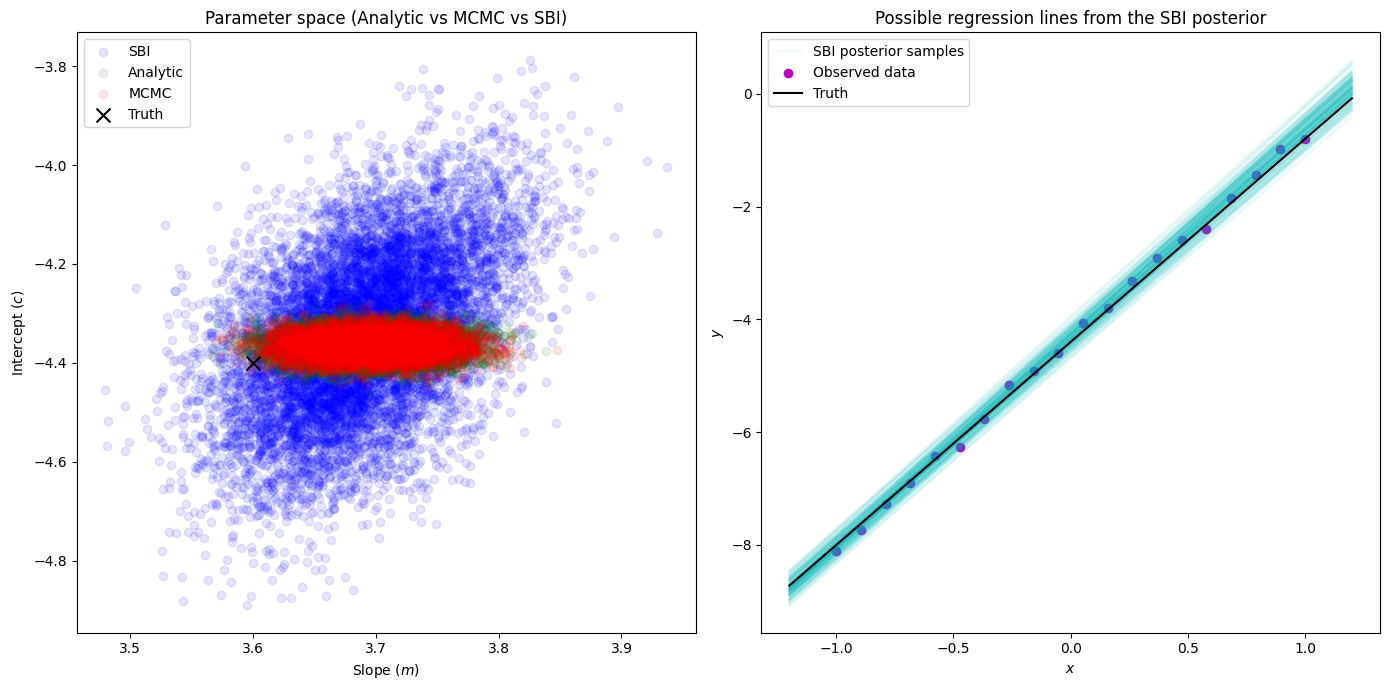

In [21]:
# MAIN SCRIPT

# 1. setup and generate observed data
device, x_grid, sigma_noise, theta_true, prior, prior_low, prior_high = problem_setup()
sim_wrapper = lambda theta: simulator(theta, x_grid=x_grid, sigma_noise=sigma_noise)
with torch.no_grad():
    y_obs = sim_wrapper(theta_true) # generate observed data

# 2. run inference methods
posterior_samples, inference = sbi(sim_wrapper, prior, y_obs) # SBI
mu_post, sigma_post = analytic_posterior(x_grid, y_obs, sigma_noise, prior_low, prior_high) # analytic
analytic_samples = torch.distributions.MultivariateNormal(mu_post, sigma_post).sample((10000,))
mcmc_samples = mcmc(x_grid, y_obs, sigma_noise) # MCMC

# 3. plot results
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

# left plot: parameter space comparison
ax[0].scatter(posterior_samples[:, 0], posterior_samples[:, 1], alpha=0.1, label="SBI", color="b")
ax[0].scatter(analytic_samples[:, 0], analytic_samples[:, 1], alpha=0.1, label="Analytic", color="g")
ax[0].scatter(mcmc_samples[:, 0], mcmc_samples[:, 1], alpha=0.1, label="MCMC", color="r")
ax[0].scatter([theta_true[0]], [theta_true[1]], marker="x", s=100, label="Truth", color="k")
ax[0].set_xlabel(r"Slope ($m$)")
ax[0].set_ylabel(r"Intercept ($c$)")
ax[0].set_title("Parameter space (Analytic vs MCMC vs SBI)")
ax[0].legend()

# right plot: posterior predictive checks
x_dense = torch.linspace(-1.2, 1.2, 100)
m0, c0 = posterior_samples[0]
ax[1].plot(x_dense, m0 * x_dense + c0, alpha=0.05, label="SBI posterior samples", color="c")
for i in range(1, 200):
    m_i, c_i = posterior_samples[i]
    ax[1].plot(x_dense, m_i * x_dense + c_i, alpha=0.05, color="c")
ax[1].scatter(x_grid, y_obs, label="Observed data", color="m")
ax[1].plot(x_dense, theta_true[0] * x_dense + theta_true[1], label="Truth", color="k")
ax[1].set_xlabel(r"$x$")
ax[1].set_ylabel(r"$y$")
ax[1].set_title("Possible regression lines from the SBI posterior")
ax[1].legend()

plt.tight_layout()
plt.show()